In [1]:
import math
import random
import os
import time
import json
from functools import partial
from collections import defaultdict

import numpy as np
import pandas as pd

%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
import keras_tuner
from tensorflow.keras.callbacks import EarlyStopping

### Check Version

In [2]:
tf.__version__

'2.9.0'

### GPU Configuration

In [3]:
gpus = tf.config.list_physical_devices('GPU')

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
tf.config.experimental.set_memory_growth(gpus[0], True)

### Pandas Config

In [6]:
pd.set_option('display.max_column', None)

### Input Pipeline

In [7]:
IMG_WIDTH = 256
IMG_HEIGHT = 256

TRAIN_BATCH_SIZE = 4
VAL_BATCH_SIZE = 4

In [8]:
CROP_WIDTH = 227
CROP_HEIGHT = 227

In [9]:
foldFiles = ["adience/unprocessed/fold_0_data.txt",
             "adience/unprocessed/fold_1_data.txt",
             "adience/unprocessed/fold_2_data.txt",
             "adience/unprocessed/fold_3_data.txt",
             "adience/unprocessed/fold_4_data.txt"]

In [10]:
genderMap = defaultdict(lambda : np.NaN)
genderMap['m'] = 0
genderMap['f'] = 1

In [11]:
ages = ['(0, 2)', '(4, 6)', '(8, 13)', '(15, 20)', '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
ageMap = defaultdict(lambda : np.NaN)
for i,a in enumerate(ages):
    ageMap[a] = i

### Dataset Generation

Dataset generation pipeline:
Input: 
- foldFile - Path to fold file. Fold file Describes which images are in the fold and its corresponding labels
- imgBaseFolder - Base folder to search image from
- imgPrefix - Prefix of image file
- genderMap - Map from ['m', 'f', 'u', None], to one hot index
- ageMap - Map from age category to one hot index
- imgWidth - Resulting image width
- imgHeigh - Resulting image height
- batchSize - Int or None, batch size
- configureDs - Function accepting dataset for performance configurations
- preBatch - List of (name, functions) pair that will be mapped before batching. name is used as name parameters for tf graph 
- postBatch - List of (name, functions) that will be mapped after batching. name is used as name parameters for tf graph

The processing functions should have signature function(img, label) -> (img, label)

Pipeline

Read Fold File -> Preprocess filename and labels (dataframe) -> Convert filename and labels to numpy array -> Convert filename and labels to tf dataset -> Parse images and labels -> Configure Dataset for performance -> Pre-Batching preprocessing -> Batch -> Post-Batching preprocessing -> Output

Some preprocessing steps can only be done before and some can only be done after batching, thats why there are seperated pre and post batching list

In [12]:
def generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, batchSize, configureDs=None, preBatch=[], postBatch=[]):
    
    def parseImage(filename):
        img = tf.io.read_file(filename)
        img = tf.image.decode_jpeg(img)
        img = tf.image.resize(img, [imgHeight, imgWidth])
         
        return img
    
    # Read Fold File
    foldData = []
    for f in foldFiles:
        foldData.append(pd.read_csv(f, sep="\t"))
    foldData = pd.concat(foldData)
    
    # Form File Name
    foldData['filename'] = foldData.apply(lambda r: os.path.join(imgBaseFolder, r['user_id'], f"{imgPrefix}.{r['face_id']}.{r['original_image']}"), axis=1)
    
    # Generate Label One Hot Index
    foldData['gender_ind'] = foldData['gender'].map(genderMap)
    foldData['age_ind'] = foldData['age'].map(ageMap)
    
    # Remove dirty data
    foldData.dropna(subset=['gender_ind', 'age_ind'], inplace=True)
    
    # Dataframe to numpy
    filenames = foldData['filename'].to_numpy()
    
    genderIndex = foldData['gender_ind'].to_numpy().astype(int)
    ageIndex = foldData['age_ind'].to_numpy().astype(int)
    
    # Numpy to Dataset
    fnDs = tf.data.Dataset.from_tensor_slices(filenames)
    genderIndDs = tf.data.Dataset.from_tensor_slices(genderIndex)
    ageIndDs = tf.data.Dataset.from_tensor_slices(ageIndex)
    
    # Parse Images
    imageDs = fnDs.map(parseImage, num_parallel_calls=tf.data.AUTOTUNE, name="parse_image")
    
    # Parse Labels
    genderLabDs = genderIndDs.map(lambda x: tf.one_hot(x, genderDepth), num_parallel_calls=tf.data.AUTOTUNE, name="gender_one_hot")
    ageLabDs = ageIndDs.map(lambda x: tf.one_hot(x, ageDepth), num_parallel_calls=tf.data.AUTOTUNE, name="age_one_hot")
    
    # Combine Labels
    labelDs = tf.data.Dataset.zip((genderLabDs, ageLabDs), name="label_zip")
    labelDs = labelDs.map(lambda g,a: {"gender": g, "age": a}, num_parallel_calls=tf.data.AUTOTUNE, name='label_dict')
    
    # Combine Images and Labels into dataset
    ds = tf.data.Dataset.zip((imageDs, labelDs))
    
    # Configure Performance
    if(configureDs is not None):
        ds = configureDs(ds)
    
    # Pre Batch Preprocessing
    for n,f in preBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    # Batch
    if(batchSize is not None):
        ds = ds.batch(batchSize, name="ds_batch")
    
    # Post Batch Preprocessing
    for n,f in postBatch:
        ds = ds.map(f, num_parallel_calls=tf.data.AUTOTUNE, name=n)
    
    return ds

### Preprocessings

In [13]:
def trainConfigPerformance(ds):
    #ds = ds.cache()
    ds = ds.shuffle(buffer_size=100)
    ds = ds.repeat()
    return ds

In [14]:
def valConfigPerformance(ds):
    #ds = ds.cache()
    return ds

#### Preprocessing steps according to the reference paper

In [15]:
def trainPreprocessA(img, lab):
        
        img = tf.image.random_crop(img, [CROP_HEIGHT, CROP_WIDTH, 3])
        
        ud = tf.random.uniform([], dtype=tf.float32)
        udCond = tf.less(ud, 0.5)
        
        img = tf.cond(udCond, lambda: tf.image.flip_up_down(img), lambda: img)
        
        lr = tf.random.uniform([], dtype=tf.float32)
        lrCond = tf.less(lr, 0.5)
        
        img = tf.cond(lrCond, lambda: tf.image.flip_left_right(img), lambda: img)
        
        img = tf.image.random_brightness(img, 63/255)
        
        img = tf.image.random_contrast(img, 0.2, 1.8)
        
        img = tf.clip_by_value(img, 0.0, 255.0)
        
        return img, lab

In [16]:
def valPreprocessA(img, lab):
        
        img = tf.image.crop_to_bounding_box(img,
                                            (IMG_HEIGHT-CROP_HEIGHT) // 2,
                                            (IMG_WIDTH-CROP_WIDTH) // 2,
                                            CROP_HEIGHT,
                                            CROP_WIDTH)
        
        return img, lab

#### Label extractor 

In [17]:
def extractGenderLabel(img, lab):
    
    lab = lab['gender']
    
    return img, lab

In [18]:
def extractAgeLabel(img, lab):
    
    lab = lab['age']
    
    return img, lab

### Generate Folds for K-Folds validation

In [19]:
def generateFoldDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, valBatchSize, trainConfigureDs=None, trainPreBatch=[], trainPostBatch=[], valConfigureDs=None, valPreBatch=[], valPostBatch=[]):
    '''
        Returns list of (train, validation) datasets
    '''
    
    N = len(foldFiles)
    
    folds = []
    
    for i in range(N):
        
        trainFiles = foldFiles[:i]
        if(i < N-1):
            trainFiles.extend(foldFiles[i+1:])
            
        valFiles = foldFiles[i]
        
        trainDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, trainBatchSize, configureDs=trainConfigureDs, preBatch=trainPreBatch, postBatch=trainPostBatch)
        valDs = generateDs(foldFiles, imgBaseFolder, imgPrefix, genderMap, ageMap, genderDepth, ageDepth, imgWidth, imgHeight, valBatchSize, configureDs=valConfigureDs, preBatch=valPreBatch, postBatch=valPostBatch)
        
        folds.append((trainDs, valDs))
        
    return folds

In [20]:
trainPreBatch = [("train_process_a", trainPreprocessA), 
                 ("train_extract_gender", extractGenderLabel)]

valPreBatch = [("val_process_a", valPreprocessA), 
               ("val_extract_gender", extractGenderLabel)]

In [21]:
folds = generateFoldDs(foldFiles, "adience/faces", "coarse_tilt_aligned_face", genderMap, ageMap, 2, 8, 
                       IMG_WIDTH, IMG_HEIGHT, TRAIN_BATCH_SIZE, VAL_BATCH_SIZE, 
                       trainConfigureDs=trainConfigPerformance, trainPreBatch=trainPreBatch, 
                       valConfigureDs=valConfigPerformance, valPreBatch=valPreBatch)

2022-11-11 00:40:01.877653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-11 00:40:02.895648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22836 MB memory:  -> device: 0, name: NVIDIA TITAN RTX, pci bus id: 0000:02:00.0, compute capability: 7.5


In [22]:
len(folds)

5

### Check data

In [23]:
for x,y in folds[0][0].take(1):
    pass

In [24]:
x

<tf.Tensor: shape=(4, 227, 227, 3), dtype=float32, numpy=
array([[[[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ]],

        [[  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [ 45.364067 ,   8.714188 ,   2.765152 ],
         ...,
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.       ],
         [  0.       ,   0.       ,   0.      

In [25]:
y

<tf.Tensor: shape=(4, 2), dtype=float32, numpy=
array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)>

<IPython.core.display.Javascript object>


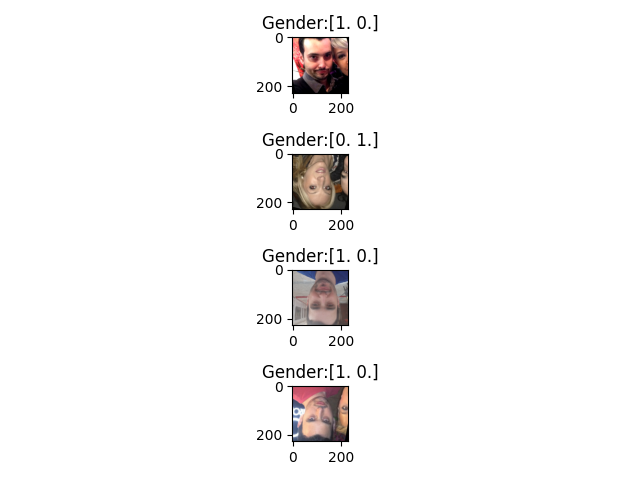

In [26]:
fig1, ax1 = plt.subplots(nrows=TRAIN_BATCH_SIZE, ncols=1)

if(TRAIN_BATCH_SIZE is None or TRAIN_BATCH_SIZE == 1):
    ax1.imshow(x/255)
    ax1.set_title(y)
else:
    for i in range(TRAIN_BATCH_SIZE):
        ax1[i].imshow(x[i]/255)
        ax1[i].set_title(f"Gender:{y[i]}")
        
plt.tight_layout()

### Model

In [27]:
def createModel(latentSize):
    inp = tf.keras.Input(shape=(CROP_HEIGHT, CROP_WIDTH, 3))

    backbone = tf.keras.applications.efficientnet_v2.EfficientNetV2M(include_top=False, input_shape=(CROP_HEIGHT, CROP_WIDTH, 3))
    backbone.trainable = False    
    
    flat1 = tf.keras.layers.Flatten(name='flat1')
    fc1 = tf.keras.layers.Dense(latentSize, activation='relu', name='fc1')
    do1 = tf.keras.layers.Dropout(0.5, name='do1')

    fc2 = tf.keras.layers.Dense(2, activation='softmax', name='fc2')

    o = tf.keras.applications.efficientnet_v2.preprocess_input(inp)
    
    # [Results]
    # EfficientNetV2-L 85.7% 120M 53B 98 24
    # EfficientNetV2-S (21k) 84.9% 22M 8.8B 24 9.0
    
    o = backbone(o, training=False)
    o = flat1(o)
    o = fc1(o)
    o = do1(o)

    o = fc2(o)

    model = tf.keras.models.Model(inputs=inp, outputs=o, name='baseline_5')
    
    return model

In [28]:
def buildModel(learningRate, latentSize):
    
    model = createModel(latentSize)

    opt = tf.keras.optimizers.Adam(learning_rate=learningRate)
    loss = tf.keras.losses.CategoricalCrossentropy()
    metrics = ['accuracy']
    
    model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
    return model

In [29]:
def hyperModel(hp):
    latentSize = hp.Int('latentSize', min_value=128, max_value=1024, step=32)
    learningRate = hp.Float('learningRate', min_value=0.00001, max_value=0.00005, sampling='log')
    
    return buildModel(learningRate, latentSize)

In [30]:
tuner1 = keras_tuner.RandomSearch(hyperModel, objective=keras_tuner.Objective('val_accuracy', 'max'), max_trials=3, project_name="efficientnet_5", overwrite=True)

### Compile Model

In [31]:
STEPS_PER_EPOCH = 1000
EPOCH = 100

START_EPOCH = 0
END_EPOCH = START_EPOCH + EPOCH

#### Learning Rate Schedule

In [32]:
def schedule(epoch, lr):
    return lr

In [33]:
logBasePath = "log/efficientnet_5_random_search"
logPrefix = "log"

In [34]:
tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}", histogram_freq=1, profile_batch=(2,10))
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=10)

2022-11-11 00:40:12.907493: I tensorflow/core/profiler/lib/profiler_session.cc:99] Profiler session initializing.
2022-11-11 00:40:12.907524: I tensorflow/core/profiler/lib/profiler_session.cc:114] Profiler session started.
2022-11-11 00:40:12.909049: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1665] Profiler found 1 GPUs
2022-11-11 00:40:12.910169: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/home/ntcadmin/env/trt-11.0/TensorRT-7.1.3.4/lib:
2022-11-11 00:40:12.910275: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so'; dlerror: libcupti.so: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/home/ntcadmin/env/trt-11.0/TensorRT-7.1.3.4/lib:
2022-11-11 00:40:12.910290: 

In [35]:
tuner1.search(
    folds[0][0], initial_epoch=START_EPOCH, epochs=END_EPOCH, validation_data=folds[0][1], callbacks=[tboardCb,es],
    steps_per_epoch = STEPS_PER_EPOCH
)

Trial 3 Complete [04h 12m 49s]
val_accuracy: 0.9303380250930786

Best val_accuracy So Far: 0.9303380250930786
Total elapsed time: 08h 18m 11s
INFO:tensorflow:Oracle triggered exit


In [36]:
for h_param in ["latentSize"] + ['learningRate']:
    print(h_param, tuner1.get_best_hyperparameters()[0].get(h_param))

latentSize 320
learningRate 1.003208925387479e-05


In [37]:
# for i, (train, val) in enumerate([folds[0]]):
    
#     model = createModel()
    
#     opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
#     loss = tf.keras.losses.CategoricalCrossentropy()
#     metrics = ['accuracy']
    
#     model.compile(optimizer=opt, loss=loss, metrics=metrics)
    
#     tboardCb = tf.keras.callbacks.TensorBoard(log_dir=f"{logBasePath}/{logPrefix}_{i}", histogram_freq=1, profile_batch=(2,10))
#     lrSchedule = tf.keras.callbacks.LearningRateScheduler(schedule)
    
#     cbs = [tboardCb]
    
#     model.evaluate(val)
#     model.fit(train, initial_epoch=START_EPOCH, epochs=END_EPOCH, steps_per_epoch=STEPS_PER_EPOCH, callbacks=cbs, validation_data=val)